# ⌚️ DM&ML 2020 - Team Rolex

## 🖋 Authors
- Francis Ruckstuhl, 16-821-738
- Hanna Birbaum, 16-050-114
- Loïc Rouiller-Monay, 16-832-453

## 🕵️ Project description

Real or Not? NLP with Disaster Tweets: Machine Learning model that can predict which tweets are about a real disaster and which are not. The project topic is based around a Kaggle competition.


## 📝 Commits

### Best commit:

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [B.] Previous commits

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [C.] Progression of accuracies

<AxesSubplot:xlabel='commit_number', ylabel='accuracy'>

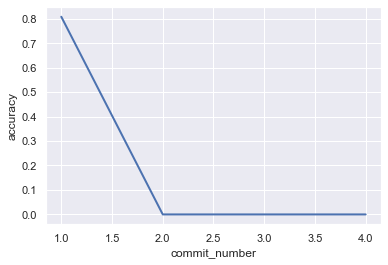

In [8]:
# /!\ You have to run Chapter 1. "libraries“ first before being able to plot the progression of accuracies
accuracy_progression = pd.read_csv('../documents/accuracy_progression.csv', sep=';')
sns.lineplot(x=accuracy_progression.commit_number, y=accuracy_progression.accuracy, linewidth=2)

# 📚 1. Libraries

In [111]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import spacy
# load English language model of spacy
sp = spacy.load('en_core_web_sm')
import string
import pycountry
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from gensim.models.doc2vec import TaggedDocument


# 📂 2. Download data


## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

In [112]:
train = pd.read_csv('../data/training_data.csv')
test = pd.read_csv('../data/test_data.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [113]:
train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


## Features
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


# 🔬 3. Exploratory Data Analysis

## [A.] What is the baserate of the problem?

In [115]:
base_rate = train.target.value_counts().max()/len(train)
print(f'\nThe base rate is {base_rate}')


The base rate is 0.5719363313243703


## Target class distribution

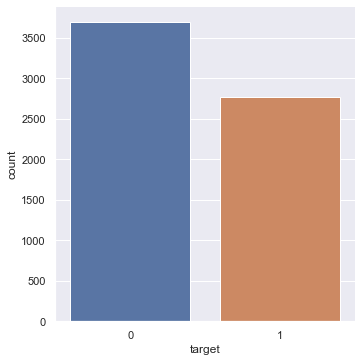

In [116]:
sns.catplot(x="target", kind="count", data=train);

## Missing values

In [117]:
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

It misses value in two features : keyword and location.

### Missing value in "keyword"

In [118]:
train.keyword.isnull().value_counts()

False    6416
True       55
Name: keyword, dtype: int64

### Missing value in "location"

In [119]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

## Tweets length

### Number of characters

In [120]:
train["num_char"] = train["text"].apply(len)

<AxesSubplot:xlabel='target', ylabel='num_char'>

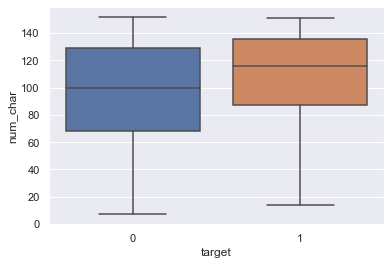

In [121]:
sns.boxplot(x='target', y='num_char', data=train)

##### Findings
Tweets about real disaster seems to be lengthier.

### Number of words

In [122]:
train["num_words"] = train["text"].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='target', ylabel='num_words'>

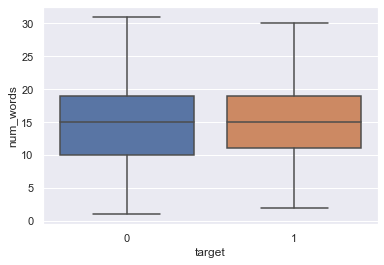

In [123]:
sns.boxplot(x='target', y='num_words', data=train)

##### Findings
Tweets about real disaster do not seem to have more words. Maybe it'll help to take this into consideration.

### Average word length

In [124]:
train["avg_word_length"] = train['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))

<AxesSubplot:xlabel='target', ylabel='avg_word_length'>

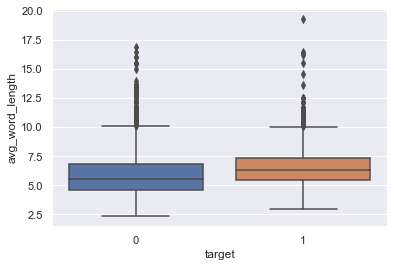

In [125]:
sns.boxplot(x='target', y='avg_word_length', data=train)

##### Findings
Tweets about real disaster seems to have lengtier average word length

### Locate disasters

In [23]:
# Where do most disasters occur / where do disaster tweets come from? 
# Potential problem to take care of: USA and United States are separate; Different US States are also separate;
train.loc[train["target"] == 1, ["location"]].value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

# 🧹 4. Data cleaning

## Keywords

In [126]:
# remove '%20' from keyword feature
train.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))
test.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))

In [25]:
# check if NaN values in the keyword feature
print(train.keyword.isnull().any())
print(test.keyword.isnull().any())

False
False


In [26]:
# use pycountry in order to check if a country appears in the location
# if yes takes the country, else turn it to NaN
# with train and test data set

In [27]:
train.location.apply(lambda x: print(x))

USA
nan
Palm Beach County, FL
USA
Australia 
Scotland
New York City
Multinational *****
Los Angeles
nan
Ad Majorem Dei Glorium
UK
GCC
New Hampshire
nan
nan
Phoenix
Oklahoma City
USA
Cumming, GA
nan
nan
Minority Privilege, USA
Brisbane Australia
nan
nan
Boston, MA
Cambridge, MA
nan
nan
Laredo, TX
Florida
Port Orange, FL
Jupiter
New York
Holly Springs, NC 
Wherever I'm needed
nan
New York City ,NY
nan
nan
nan
nan
Copenhagen, Capital Region of Denmark
United Kingdom
ilford
nan
Chippenham/Bath, UK
UK & Ibiza
San Diego California 92101
Dundee, UK
Wiltshire
Reading UK
nan
Earth 0
New York
India
Oklahoma City, OK
New York 
Shelby County
 Road to the Billionaires Club
nan
Chicago, IL 60607
1313 W.Patrick St, Frederick
nan
Leesburg, FL
Spain - China - Latin America.
Epic City, BB.
Jackson
Far Away From Home
Absecon, NJ
nan
Seattle
nan
United States
nan
nan
Memphis, TN
nan
Boise, Idaho
Alexandria, VA
State College, Pa
?????? ??? ?????? ????????
State College, PA
UK
canberra
Varanasi
Haysville, K

nan
nan
Plano, Texas
nan
United Kingdom
nan
nan
San Antonio, TX
Toronto, Worldwide 
San Diego, Calif.
nan
nan
nan
Brazil
Bangalore
Adelaide, Australia
nan
IM LOST 
Cape Town
Nashville, TN
Making Worldwide Change Near U
nan
nan
Norway
Slappin and Smackin 
USA
The Netherlands
304
London
Sioux Falls, SD
NJ
Jamshedpur, Jharkhand
nan
nan
Tokyo
Canada
Los Angeles, CA
rural ohio (fuck)
United States
Virginia
maryland
Park Ridge, Illinois
nan
nan
nan
nan
MAURITIUS
Port Harcourt, Nigeria
nan
nan
BIG D  HOUSTON/BOSTON/DENVER
Sherwood, Brisbane, Australia
nan
#HAMont
I rap to burn shame.
nan
Canada
Norwich
nan
nan
nan
EIC
Odawara, Japan
nan
nan
Live4Heed??
ÌÏT: 36.142163,-95.979189
Africa
nan
New Britain, CT
nan
nan
U.S.
nan
LA ??
New Jersey
nan
ÌÏT: 27.9136024,-81.6078532
570 Vanderbilt; Brooklyn, NY
World
potters bar
probably watching survivor
nan
nan
Cardiff, UK
Washington, Krasnodar (Russia)
Skyhold
Tulsa, OK
hey Georgia
Midwestern USA
Helsinki, Finland
Chicago, IL
ÌÏT: 10.614817868480726,12.

nan
nan
nan
Dallas, TX
nan
Melbourne-ish
Massachusetts
nan
nan
Madison, GA
IUPUI '19
Heaven
Mumbai
Budapest, Hungary
Selma2Oakland
St Austell, Cornwall
Massachusetts
nan
nan
Brizzle City !
nan
nan
Charlotte NC
winston-salem north carolina
Oregon, USA
Noida, NCR, India
nan
Tulsa, Oklahoma
NC
United States
Houston
Hawthorne, NE
Los Angeles
USA
London, UK
Toronto, Ontario
nan
West Virginia, USA
CA
nan
IDN
Concord, N.C.
Los Angeles, CA
london
hatena bookmark
London
New York City
nan
UK
In the clouds...
nan
Washington
MAD as Hell
nan
nan
SWMO
London
BrasÌ_lia
Aarhus, Central Jutland
USA
Nairobi , Kenya
nan
New York, USA
somewhere in Indiana 
Tampa, FL
United States
MIchigan
Washington, DC
In your mind
nan
nan
Bedford IN 
World
Jaipur, Rajasthan, India
Hilton Head, SC  
Dallas, Tejas
nan
Oakland, CA
Macclesfield
nan
nan
nan
Brum/Lestah 
RSN: Tru
nan
Aveiro, Portugal
Washington, DC
New Delhi, India
new york
nan
Lincoln, IL
nan
Winter Park, Colorado
Burbank,CA
Everywhere
Houston, TX
nan
Doghou

nan
Swaning Around
nan
Bhopal, Madhya Pradesh, India.
Nadiad ,Gujarat , India!!
North Ferriby, East Yorkshire
New York City
United States
nan
Sydney & Worldwide
hell
IRAQ
california | oregon | peru |
nan
nan
Poconos
Asheboro, NC
nan
sweden
nan
nan
BKI-KUA
USA
Ottawa, Canada
Benicia, CA 
Cavite, Philippines
yorkshire

11202
Hong Kong
India
nan
Dallas, Texas. 
Calgary, Alberta
nan
nan
Dime's Palace
St Joseph de Beauce
San Diego
@cockerelshoes
Washington state
Cape Town
nan
San Diego, CA
nan
Greater Los Angeles Bearia
Sarasota, FL
nan
nan
Philadelphia, PA
at my home
Fairgrounds Resident
nan
Oshawa, Canada
nan
Killafornia made me 
Kent
China
New Sweden
nan
St. Joseph, Minnesota
nan
Morioh, Japan
Fort Calhoun, NE
IG: AyshBanaysh
nan
Canada
World
Moore, OK
New York
New York
nan
PROV
nan
nan
Dime's Palace
ph
nearest trash can 
New Orleans, Louisiana
nan
nan
nan
online 
Denver, Colorado
USA
nan
Southern California
Homs- Syria
Nigeria
nan
Cape Cod
Nowhere Islands/Smash Manor
Ely, Cambridgeshire

nan
nyc
nan
Greenpoint
nan
nan
Nevada (wishing for Colorado)
nan
UK
You're not 19 forever   
Ireland
houstn
Houston TX
Tampa, FL
BROOKLYN, NYC
nan
London, England
nan
North Carolina
MUM-DEL
Portland, Oregon
India
Oregon, USA
Pennsylvania
ducked off . . . 
nan
Here.
world
The Forever Girl
nan
nan
Click the link below, okay 
nan
Somecity, Somerset, MD
Atlanta, GA
nan
somewhere in Portugal
nan
nan
Fort Worth, Texas
Western New York
nan
Barbados
Reston, VA, USA
nan
Dindigul,TamilNadu.
Mount Vernon, NY
Fukushima city Fukushima.pref
Atlanta, GA
nan
nan
buhh
Suginami-ku, Tokyo, Japan
nan
  News
Freeport IL. USA
nan
nan
L. A.
Winston Salem, North Carolina
nan
nan
Atlanta Georgia 
nan
My mind is my world
Alexandria, Egypt.
Chicago IL
nan
Bucks County, Pa
Calgary, AB
USA
The Multiverse
Atlantic Highlands, NJ
nan
Indiana
Kilkenny
nan
Bathtub de Bett 
nan
Oregon and Washington
nan
Belgium
Lancaster, CA
Westerland
nan
 Quantico Marine Base, VA.
Na waffi
Co. Tyrone Northern Ireland
Australia
nan
nan

nan
Atlanta Georgia
nan
Kicking Horse Pass
United Kingdom
Korea
Michigan
New York
Rural Northern Nevada
nan
Belbroughton, England
nan
Quilmes , Arg
nan
nan
nan
Cimahi,West Java,Indonesia
nan
å¡å¡Midwest Û¢Û¢
Chicago, IL
Oxford, OH
brooklyn, NYC
@ ForSL/RP
Cape Town
Nashville, TN
nan
oman muscat al seeb 
somewhere USA 
Aro Diaspora
nan
nan
nan
nan
Amman,Jordan
Montgomery, AL
nan
Vidalia GA
nan
nan
New Orleans ,Louisiana
Colorado
From NY. In Scranton, PA
USA
nan
tokyo
Australia
nan
nan
Kama | 18 | France 
nan
nan
United States
China
The Wood
nan
#937??#734
St Paul, MN
Chicago, IL
nan
marysville ca 
nan
Erie, PA
Louisiana
labyrinthia
USA
nan
South, USA
Marrakech MÌ©dina, Marrakech - Tensift - Al Haouz
planet earth
Galveston, Texas
dmv ?? fashion school @ KSU. 
nan
nan
Arizona
nan
everywhere 
Macclesfield
304
nan
Harlingen, TX
Just Happy to Be Anywhere
nan
walking the tightrope
Tampa, Fl
Anonymous
USA
New York
Hope Road, Jamaica 
nan
Southern Califorina
nan
nan
nan
GLOBAL
Huber Heights, 

Boston, MA
THANJAVUR
Pittsburgh 
Minna, Nigeria
Upstate New York
Australia
nan
Mostly Yuin.
Watch Those Videos -
Pennsylvania, USA
Netherlands,Amsterdam-Virtual 
New York
justin & ari follow || tvd
nan
nan
Gold Coast, Australia
nan
Raleigh, NC
South Carolina
Vancouver, British Columbia
11/4/14
Charlotte, NC
Pakistan
Alger-New York-San Francisco
Croydon
LA/OC/Vegas
107-18 79TH STREET
Planet Earth
nan
USA
ss
London
Ab, Canada
nan
Montana, USA
nan
England
New York
nan
3?3?7?SLOPelousas??2?2?5?
3.28.15|7.20.15|7.25.15
Washington, DC
nan
The Epicenter, and Beyond
nan
Konoha Village
304
We are global!
nan
Galapa / AtlÌÁntico
Long Beach, CA
Portland, OR
Morocco
nan
India
Paterson, New Jersey 
Houston, TX
U.S.A
Kenya
Penn Hills, PA
Northern Colorado
Singapore
nan
nan
nan
Durban, South Africa
10 Steps Ahead.  Cloud 9
United Kingdom
Texas, USA
have car; will travel
New Orleans, LA
nan
London
nan
nan
back in japan ??????????
Lagos, Nigeria
Nashville, Tn
nan
nan
nan
Colombo,Sri Lanka.
Robin Hood's

0       None
1       None
2       None
3       None
4       None
        ... 
6466    None
6467    None
6468    None
6469    None
6470    None
Name: location, Length: 6471, dtype: object

## Text

In [127]:
def clean_text(text):
    # remove unicode literals
    temp = text.encode('ascii',errors='ignore').decode('ascii')
    
    # remove &amp
    temp = temp.replace('&amp;', '')
    
    # remove urls
    temp = re.sub(r"http\S+", "", temp)
    
    # remove html
    temp = re.sub(r'<.*?>', "", temp)
    
    # remove hashtags
    temp = re.sub(r'#', "", temp)

    # remove people account with @
    temp = re.sub(r'@\S+', "", temp)
    
    return temp

In [128]:
# clean text
train.text = train.text.apply(lambda x: clean_text(x))

In [32]:
# todo: régler les problèmes d'encodage: Ûª, Û_, Ûª, &amp, ;#number_of_any_length;
# création d'une expression regulière; could be helpful to remove these:
# regex = re.compile(r"(Ûª|Û_|Ûª|&amp|(\d+)|((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*))")

# enlever les liens, juste les hashtags, lowercase, ponctuation
# en option voir si enlever les "@ + les pseudos" ça aide

In [129]:
train.text.apply(lambda x: print(x))

Black Eye 9: A space battle occurred at Star O784 involving 3 fleets totaling 3945 ships with 17 destroyed
world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  
Reality Training: Train falls off elevated tracks during windstorm  Paramedic EMS
Taiwan Grace: expect that large rocks trees mud unstable and/or saturated land may slide ..very hazardous in hilly/mountain areas...
New ISIS Video: ISIS Threatens to Behead Croatian Hostage Within 48 Hours - TLVFaces - TLVFacesauspol 
FreeBesieged: .MartinMJ22 YouGov Which 'Tory landslide' ... you can't POSSIBLY mean the wafer-thin majority of G_ 
Billionaires have a plan to free half a billion dollars trapped in Venezuela for two years  reports.


 Some old testimony of weapons used to promote conflicts
Tactics - corruption  infiltration of groups

Ali you flew planes and ran into burning buildings why are you making soup for that man child?! BooRadleyVanCullen
The thunder shook my house woke my sister and made car 

Philippines Must Protect Internally Displaced Persons Warns UN Expert 
Horror films are made by incredibly creative artists. We interviewed 21 of them in depth for The Anatomy of Fear. 
Trauma can happen anywhere -- school home etc. -- at any time. Learn the ABC's of trauma and how to parent... _ 
Success is not permanent  failure is not fatal.
 Gd ideas. I'm 77 wrked hard now have almost nothing fear lives with poor
Fran Reed 8437150124
Photo: postapocalypticflimflam: Prodding around the rubble. 
PRAY! For EAST COAST FOREST FIRES! PRAY! That they be put out. PRAY! For RAIN!
Man is reading a list of famous musicians who oppose nuclear power...wow powerful evidence. They must know a lot about seismic risks....
 TY for the follow Go To  BRUTALLY ABUSED+DESOLATELOST + HER LOVELY MUM DIES..Is it Murder?
Spot fixing/match fixing ..anyone???
Or it has to be Pak SL WI RSA or BD to say this. Sham on them who say that when these team collapse
I hope the only time I end up on TV is when I'm bein

Lightning strike in the distance via /r/pics  pics
 what if I'm drowning
&lt;meltdown of proportions commences I manage to calm myself long enough to turn the waters to hot and wait for the steam to cloud my vision-
Obliterated my phone screen today with a drum stick. blessed
Don't mess with my Daddy I can be a massacre. BeCarefulHarry
Sinkhole Disrupts Downtown Trolley Service SanDiego - 
Traffic accident N CABRILLO HWY/MAGELLAN AV MIR (08/06/15 11:03:58)
Can you list 5 reasons why a London TubeStrike is better than a Snowstorm? Read here... 
Providence Health  Services: Emergency Services Supervisor - Emergency Department... (Kodiak AK)  Healthcare Job
Stuart Broad Takes Eight Before Joe Root Runs Riot Against Aussies
Crazy Mom Threw Teen Daughter a NUDE Twister Sex Party According To Her Friend59 more pics  
7:13pm MAPLERIDGE Lougheed Hwy EB is closed between 203rd and Dewdney Trunk Rd because of Collision. ETO is between 8:00 PM and 9:00 PM.
Police kill gunman at Nashville movie th

Ignition Knock (Detonation) Sensor-Senso Standard KS94  
Survived another tube strike with the last person at office reaching home. We are getting better at navigating strikes!
Alabama firefighters quarantined after possible Ebola exposure  reports 
Falling asleep to the sounds to thousands of River Plate fans in the stadium and a thunderstorm. VivaArgentina
Detonate (feat. M?.?O?.?P?.?)
from Grandeur by Apollo Brown 
Huge cliff landslide on road in China: Watch the moment a cliff collapses as huge chunks of rock fall onto a r... 
Wholesale WE Gon Rep That $hit At All Costs- Hazardous WholeTeam3 WholesaleEnt 
Free Ebay Sniping RT?  Lumbar Extender Back Stretcher Excellent Condition!! ?Please Favorite  Share
  together we can destroy the Emperor and rule the galaxy Father and Son!
Kids Disappear in Dust Storm in Atmospheric Aussie Thriller  RT 
Releases on the planing level -

1. Constellation - Blight on Gaia - iClown's Drumstep Remix
2.iClown - Infinity... 
late night mcdonalds with f

0       None
1       None
2       None
3       None
4       None
        ... 
6466    None
6467    None
6468    None
6469    None
6470    None
Name: text, Length: 6471, dtype: object

## Location

In [11]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

# 🛠 [D.] 5. Feature Engineering

In [56]:
pycountry.countries.search_fuzzy('England')

[Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')]

In [107]:
# not good 

def location_to_country(location):
    temp = location.split(',')
    countries = list(pycountry.countries)
    
    for word in temp:
        for i in range(len(countries)):
            if (word.strip() in countries[i].alpha_2) or (word.strip() in countries[i].alpha_3) or (word.strip() in countries[i].name):
                return countries[i].name
    return 'Unknown'

train['country'] = train.location.apply(lambda x: location_to_country(str(x)))
train[['location', 'country']].head(60)

# ⚙️ 6. Preprocessing

In [130]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    # numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove all word with less that 3 letters (remove noise)
    mytokens = [ word for word in mytokens if len(word)>2 ]

    # Return preprocessed list of tokens
    return mytokens

In [131]:
# Tokenize texts
processed_texts = []
for text in train.text:
    processed_text = spacy_tokenizer(text)
    processed_texts.append(processed_text)

# 🤖 7. Models

## BOW with Logistic Regression

In [168]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit_transform(train.text)

In [169]:
# Get feature names
feature_names = count.get_feature_names()

In [170]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [139]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [140]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=3)

In [142]:
# Fit model on training set
classifier.fit(X_train, y_train)

LogisticRegressionCV(cv=3, max_iter=5000)

In [143]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7931


#### BOW with more additional features

In [171]:
train_full = pd.concat([train[['num_char', 'num_words', 'avg_word_length']], processed_train], axis=1)

In [172]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [173]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=10000, cv=4)

In [174]:
%%time
# Fit model on training set
classifier.fit(X_train, y_train)

LogisticRegressionCV(cv=4, max_iter=10000)

In [175]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7938


#### BOW with additional features and Decision tree

In [ ]:
train_full = pd.concat([train[['num_char', 'num_words', 'avg_word_length']], processed_train], axis=1)

In [ ]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [149]:
# Define classifier
classifier = DecisionTreeClassifier()

In [150]:
# Fit model on training set
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [151]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7459


## TF-IDF with Logistic Regression

In [69]:
# Select features
X = train['text'] # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [82]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

CPU times: user 1min 22s, sys: 1.82 s, total: 1min 24s
Wall time: 1min 37s


/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=5, sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', LogisticRegressionCV(cv=5, max_iter=1000))])

In [83]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7776


## Decision tree

In [73]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = DecisionTreeClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

CPU times: user 1min 14s, sys: 1.74 s, total: 1min 16s
Wall time: 1min 41s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', DecisionTreeClassifier())])

In [74]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7205


## Classification using Doc2Vec and Logistic Regression

In [84]:
sample_tagged = train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)

In [85]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

In [86]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [99]:
# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=1, vector_size=100, negative=5, hs=0, min_count=1, sample=0, workers=cores, epoch=500)
model_dbow.build_vocab([x for x in train_tagged.values])

In [100]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [101]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=300)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

# Each document (i.e. complaint) is now a vector in the space of 30 dimentions.
# Similar complaints should have similar vector representation.

In [102]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegression(max_iter=10000, solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [103]:
# Predictions
y_pred = logreg.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7846


## Classification using Doc2Vec, more features and Logistic Regression

# 🏆 8. Submission

In [28]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

In [29]:
pipe.fit(train.text, train.target)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000001A08775D040>)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [30]:
preds = pipe.predict(test.text)

In [31]:
preds

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [32]:
sample_submission.target = preds

In [33]:
sample_submission

,target
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [35]:
sample_submission.to_csv('submission-001.csv', index=False)